# Coursera Capstone Project Code

First I'm going to split the city into Neighbourhoods. To start, I'll import all the relevant packages that I'll be using.

In [1]:
import numpy as np 
import pandas as pd 
import json
from geopy.geocoders import Nominatim 
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import urllib

print('Libraries imported.')

Libraries imported.


Now I'm going to download the geojson file containing the information on the neighbourhoods of Toronto as found in the [City of Toronto's Open Data Catalogue](https://open.toronto.ca/dataset/neighbourhoods/).

In [0]:
!wget -q -O 'toronto_data.geojson' https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/a083c865-6d60-4d1d-b6c6-b0c8a85f9c15?format=geojson&projection=4326

Let's take a look at some of what we've just downloaded.

In [3]:
with open('toronto_data.geojson', 'r') as f:
    toronto_data = json.load(f)

neighbourhoods_data = toronto_data['features']
neighbourhoods_data[0]

{'geometry': {'coordinates': [[[-79.43591570873059, 43.68015339477487],
    [-79.43491506339724, 43.68036886994886],
    [-79.43394727223847, 43.680578504490335],
    [-79.43388162422195, 43.68058996121469],
    [-79.43281544978878, 43.680808044458765],
    [-79.4326971769691, 43.68079658822322],
    [-79.43253064659865, 43.68082785962871],
    [-79.43245944449654, 43.68085882710364],
    [-79.43241132723996, 43.68089794537263],
    [-79.43094766397957, 43.681205221508016],
    [-79.429092835633, 43.681595102987544],
    [-79.42903365882387, 43.681449668075835],
    [-79.42785970191096, 43.681692562729424],
    [-79.4263441163887, 43.68201825378964],
    [-79.42640038491278, 43.682163706208954],
    [-79.42628766052025, 43.682188126141014],
    [-79.4261932417882, 43.681960611092485],
    [-79.42470874825375, 43.682295634883694],
    [-79.42457946073631, 43.682323264689146],
    [-79.42465561769507, 43.68250024466668],
    [-79.42385943787588, 43.68266387400368],
    [-79.4235480049049

Here we can see that this geojson file includes a lot of coordinates for each feature. These coordinates denote a polygon that outlines each given neighbourhood. This file also contains the name of the neighbourhood.

Before we dive too deep into all of the features, let's first visualize these neighbourhoods.


In [4]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

m = folium.Map(location=[latitude, longitude], zoom_start=10)
style_function = lambda x: {'fillColor': '#593dba', 'fillOpacity': '15%', 'color': '#361c94'}
folium.GeoJson(toronto_data, name='geojson', style_function=style_function).add_to(m)

m.save('toronto_map.html')

def embed_map(m):
    from IPython.display import HTML

    m.save('index.html')
    with open('index.html') as f:
        html = f.read()

    iframe = '<iframe srcdoc="{srcdoc}" style="width: 100%; height: 750px; border: none"></iframe>'
    srcdoc = html.replace('"', '&quot;')
    return HTML(iframe.format(srcdoc=srcdoc))


embed_map(m)


This is a great visual of the neighbourhoods of Toronto, but for our analysis, it will be more convenient to simplify this data to a single latitude/longitude pair for each neighbourhood. We will create a new dataframe with just the centre of each neighbourhood as the latitude/longitude.

In [5]:
column_names = ['Neighbourhood', 'Latitude', 'Longitude']
neighbourhoods = pd.DataFrame(columns=column_names)
for data in neighbourhoods_data:
    neighbourhood_name = data['properties']['AREA_NAME']
    neighbourhood_lat = data['properties']['LATITUDE']
    neighbourhood_lon = data['properties']['LONGITUDE']
    
    neighbourhoods= neighbourhoods.append({
                                          'Neighbourhood': neighbourhood_name,
                                          'Latitude': neighbourhood_lat,
                                          'Longitude': neighbourhood_lon}, ignore_index=True)

#get rid of the area code in brackets
neighbourhoods['Neighbourhood'] = neighbourhoods['Neighbourhood'].str.rsplit(' ',1).str[0]

neighbourhoods

Neighbourhood   Latitude  Longitude
0                         Wychwood  43.676919 -79.425515
1                   Yonge-Eglinton  43.704689 -79.403590
2                   Yonge-St.Clair  43.687859 -79.397871
3          York University Heights  43.765736 -79.488883
4               Yorkdale-Glen Park  43.714672 -79.457108
..                             ...        ...        ...
135                   Kennedy Park  43.725556 -79.260382
136           Kensington-Chinatown  43.653554 -79.397240
137  Kingsview Village-The Westway  43.698993 -79.547863
138                 Kingsway South  43.653520 -79.510577
139                     L'Amoreaux  43.795716 -79.314084

[140 rows x 3 columns]

We now have a pared down dataframe containing only the neighbourhood names and the coordinates of their centres. Let's take a look at this on our map.

In [6]:
# add markers to map
for lat, lng, neighborhood in zip(neighbourhoods['Latitude'], neighbourhoods['Longitude'], neighbourhoods['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        popup=label,
        radius = 5,
        color='#5ac6ed',
        opacity = 0.7,
        fill=True,
        fill_color='#5ac6ed',
        fill_opacity=0.7,
        parse_html=False).add_to(m)  

m.save('toronto_map.html')

def embed_map(m):
    from IPython.display import HTML

    m.save('index.html')
    with open('index.html') as f:
        html = f.read()

    iframe = '<iframe srcdoc="{srcdoc}" style="width: 100%; height: 750px; border: none"></iframe>'
    srcdoc = html.replace('"', '&quot;')
    return HTML(iframe.format(srcdoc=srcdoc))


embed_map(m)


Now, let's pull some venue data from Foursquare!

In [7]:
CLIENT_ID = 'CKMK1K0BXXB2A21YGPLTOGAEE10PDZRFFVABYKYDOD5NANGK' # your Foursquare ID
CLIENT_SECRET = 'E2GNBAKVUS5UL4MAOFKWAMQKCDPRKWHOLMNJ4ZMUZETA3DPK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CKMK1K0BXXB2A21YGPLTOGAEE10PDZRFFVABYKYDOD5NANGK
CLIENT_SECRET:E2GNBAKVUS5UL4MAOFKWAMQKCDPRKWHOLMNJ4ZMUZETA3DPK


Let's set our radius to 1000m, as it is a reasonable walking distance. We can prepare our url for our venue searches

In [0]:
radius = 1000
LIMIT = 100
neighbourhood_latitude = neighbourhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighbourhood_longitude = neighbourhoods.loc[0, 'Longitude'] # neighborhood longitude value
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighbourhood_latitude, neighbourhood_longitude, VERSION, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['groups'][0]['items']

I'll now create a function to count the number of venues of each of a given category within the defined search radius of each neighbourhood.

In [0]:

def Get_Number_Of_Venues(ID, category):
    for i in range(len(neighbourhoods)):
        p_lat =neighbourhoods.iloc[i,1]
        p_lon =neighbourhoods.iloc[i,2]
        Radius = 1000
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,p_lat,p_lon,VERSION,ID,Radius,LIMIT) 
        test_results = requests.get(url).json()
        test_venue = test_results['response']['venues']
        count = np.shape(test_venue)
        neighbourhoods.loc[i, category] = count[0]

Now, let's create new columns in our dataframe for the location types we want to search. In this instance, we want to assess each neighbourhood by the number of nearby schools, libraries, and childcare options.

In [10]:
neighbourhoods['School'] = ''
neighbourhoods['Library'] = ''
neighbourhoods['Childcare'] = ''
neighbourhoods.head()

Neighbourhood   Latitude  Longitude School Library Childcare
0                 Wychwood  43.676919 -79.425515                         
1           Yonge-Eglinton  43.704689 -79.403590                         
2           Yonge-St.Clair  43.687859 -79.397871                         
3  York University Heights  43.765736 -79.488883                         
4       Yorkdale-Glen Park  43.714672 -79.457108

Finally, we can run our function on these three categories of locations.

In [11]:
Get_Number_Of_Venues( '4bf58dd8d48988d13b941735','School')
Get_Number_Of_Venues( '4bf58dd8d48988d12f941735','Library')
Get_Number_Of_Venues( '5744ccdfe4b0c0459246b4c7','Childcare')

neighbourhoods.head(30)

Neighbourhood   Latitude  ...  Library  Childcare
0                              Wychwood  43.676919  ...        3          4
1                        Yonge-Eglinton  43.704689  ...        5          0
2                        Yonge-St.Clair  43.687859  ...        3          0
3               York University Heights  43.765736  ...        0          0
4                    Yorkdale-Glen Park  43.714672  ...        0          1
5                    Lambton Baby Point  43.657420  ...        1          1
6                      Lansing-Westgate  43.754271  ...        0          0
7                   Lawrence Park North  43.730060  ...        2          0
8                   Lawrence Park South  43.717212  ...        3          0
9                    Leaside-Bennington  43.703797  ...        3          3
10                      Little Portugal  43.647536  ...        3          3
11                          Long Branch  43.592362  ...        1          2
12                              Malvern  43.803658  ...        1          0
13                           Maple Leaf  43.715574  ...        2          0
14                        Markland Wood  43.633542  ...        0          0
15                             Milliken  43.820691  ...        1          0
16  Mimico (includes Humber Bay Shores)  43.615924  ...        1          0
17                          Morningside  43.782399  ...        0          0
18                            Moss Park  43.656518  ...        8          3
19                         Mount Dennis  43.688144  ...        1          0
20    Mount Olive-Silverstone-Jamestown  43.746868  ...        2          1
21                  Mount Pleasant East  43.704852  ...        4          4
22                  Mount Pleasant West  43.704435  ...        6          2
23                          New Toronto  43.600589  ...        1          1
24                     Newtonbrook East  43.791536  ...        1          0
25                     Newtonbrook West  43.785830  ...        0          0
26                              Niagara  43.636681  ...        5          2
27                      North Riverdale  43.671995  ...        2          3
28                  North St.James Town  43.669623  ...        9          3
29                    O'Connor-Parkview  43.706800  ...        1          1

[30 rows x 6 columns]

This is great - we can see which neighbourhoods have the highest number of the features that we're looking for.

Before I set out to cluster the data, I want to normalize it.

In [0]:
neighbourhoods_orig = neighbourhoods.copy()

In [0]:
import pandas as pd
from sklearn import preprocessing
#School
school_flt = neighbourhoods[['School']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
school_flt_scaled = min_max_scaler.fit_transform(school_flt)
school_normalized = pd.DataFrame(school_flt_scaled)

#Library
lib_flt = neighbourhoods[['Library']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
lib_flt_scaled = min_max_scaler.fit_transform(lib_flt)
lib_normalized = pd.DataFrame(lib_flt_scaled)

#Child Care
cc_flt = neighbourhoods[['Childcare']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
cc_flt_scaled = min_max_scaler.fit_transform(cc_flt)
cc_normalized = pd.DataFrame(cc_flt_scaled)

In [0]:
neighbourhoods['School'] = school_normalized
neighbourhoods['Library'] = lib_normalized
neighbourhoods['Childcare'] = cc_normalized

In [15]:
neighbourhoods.head()

Neighbourhood   Latitude  Longitude    School   Library  Childcare
0                 Wychwood  43.676919 -79.425515  0.285714  0.200000   0.666667
1           Yonge-Eglinton  43.704689 -79.403590  0.673469  0.333333   0.000000
2           Yonge-St.Clair  43.687859 -79.397871  0.408163  0.200000   0.000000
3  York University Heights  43.765736 -79.488883  0.061224  0.000000   0.000000
4       Yorkdale-Glen Park  43.714672 -79.457108  0.244898  0.000000   0.166667

In [16]:
neighbourhood_cluster = neighbourhoods.iloc[:,3:]
neighbourhood_cluster.head()

School   Library  Childcare
0  0.285714  0.200000   0.666667
1  0.673469  0.333333   0.000000
2  0.408163  0.200000   0.000000
3  0.061224  0.000000   0.000000
4  0.244898  0.000000   0.166667

Next, let's cluster these neighbourhoods into three distinct clusters.

In [0]:
num = 3
neighbourhood_kmeans = KMeans(n_clusters = num, random_state = 0).fit(neighbourhood_cluster)

In [0]:
neighbourhoods.insert(0,'Cluster Labels', neighbourhood_kmeans.labels_)


In [19]:
neighbourhoods.head()

Cluster Labels            Neighbourhood  ...   Library  Childcare
0               1                 Wychwood  ...  0.200000   0.666667
1               2           Yonge-Eglinton  ...  0.333333   0.000000
2               0           Yonge-St.Clair  ...  0.200000   0.000000
3               0  York University Heights  ...  0.000000   0.000000
4               0       Yorkdale-Glen Park  ...  0.000000   0.166667

[5 rows x 7 columns]

I'll name our clusters and save each as it's own dataframe

In [0]:
Neighborhoods_Best = neighbourhoods[neighbourhoods['Cluster Labels'] == 2]
Neighborhoods_Okay = neighbourhoods[neighbourhoods['Cluster Labels'] == 1]
Neighborhoods_Nonideal = neighbourhoods[neighbourhoods['Cluster Labels'] == 0]

To double-check that the choice of 3 clusters is the most optimal, I will run the elbow method. 

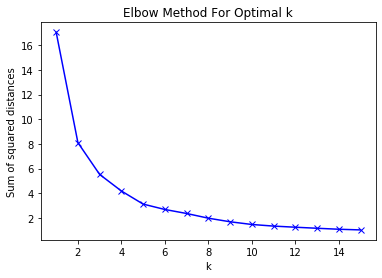

In [21]:
elbow = []
for k in range(1,16):
    km = KMeans(n_clusters = k, random_state = 0).fit(neighbourhood_cluster)
    elbow.append(km.inertia_)
import matplotlib.pyplot as plt
K = range(1,16)
#plt.figure(figsize =(30,20))
plt.plot(K,  elbow,'bx-')
plt.xlabel('k')  
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Since the "elbow" - that is, the point directly after which the sum of squared distances starts decreasing in a linear fashion - is 3, we know that 3 is the best k-value. Now I'll go ahead and visualize these clusters on our map.

In [22]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

cluster_map = folium.Map(location = [latitude, longitude], zoom_start = 10)
for lat, lng, neighbourhood, cluster in zip(neighbourhoods['Latitude'], neighbourhoods['Longitude'], neighbourhoods['Neighbourhood'], neighbourhoods['Cluster Labels']):
    label = 'Cluster #: {} Neighbourhood: {}'.format(cluster, neighbourhood)
    label = folium.Popup(label, parse_html = True)
    if cluster == 0:
        color="#fff763" 
    elif cluster == 1:
        color = "#99b846"
    else: 
        color="green"
    folium.CircleMarker([lat, lng], 
                        radius = 4, 
                        popup = label, 
                        color = color,
                        fill = True, 
                        fill_opacity = 0.6, 
                        parse_html = False).add_to(cluster_map)
cluster_map

This allows us to visualize the locations of the most ideal neighbourhoods for young families in Toronto.

In [23]:
sorted_df = Neighborhoods_Best.sort_values(by = 'School', axis = 0, ascending = False)                                            
sorted_df.reset_index(drop = True, inplace = True)
sorted_df.head(20)

Cluster Labels                    Neighbourhood  ...   Library  Childcare
0                2                       University  ...  0.800000   0.333333
1                2             Kensington-Chinatown  ...  0.933333   0.166667
2                2            Church-Yonge Corridor  ...  0.733333   0.500000
3                2              Bay Street Corridor  ...  1.000000   0.333333
4                2                            Annex  ...  0.666667   0.333333
5                2              Mount Pleasant West  ...  0.400000   0.333333
6                2          Palmerston-Little Italy  ...  0.133333   0.166667
7                2                   Dufferin Grove  ...  0.200000   0.166667
8                2                   Yonge-Eglinton  ...  0.333333   0.000000
9                2                        Moss Park  ...  0.533333   0.500000
10               2              North St.James Town  ...  0.600000   0.500000
11               2                Trinity-Bellwoods  ...  0.200000   0.333333
12               2  Cabbagetown-South St.James Town  ...  0.333333   0.166667

[13 rows x 7 columns]

In [24]:
Neighborhoods_Best['Total_Score'] = Neighborhoods_Best['School'] + Neighborhoods_Best['Library'] + Neighborhoods_Best['Childcare']
Neighborhoods_Best.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Cluster Labels            Neighbourhood  ...  Childcare  Total_Score
1                2           Yonge-Eglinton  ...   0.000000     1.006803
18               2                Moss Park  ...   0.500000     1.706803
22               2      Mount Pleasant West  ...   0.333333     1.447619
28               2      North St.James Town  ...   0.500000     1.773469
33               2  Palmerston-Little Italy  ...   0.166667     1.014286

[5 rows x 8 columns]

In [48]:
Top_5 = Neighborhoods_Best.sort_values(by = 'Total_Score', axis = 0, ascending = False)                                            
Top_5.reset_index(drop = True, inplace = True)
Top_5.drop('Latitude', axis=1, inplace=True)
Top_5.drop('Longitude', axis=1, inplace=True)
Top_5.drop('School', axis=1, inplace=True)
Top_5.drop('Library', axis=1, inplace=True)
Top_5.drop('Childcare', axis=1, inplace=True)
Top_5.drop('Cluster Labels', axis=1, inplace=True)
Top_5.head()

Neighbourhood  Total_Score
0    Bay Street Corridor     2.170068
1             University     2.133333
2  Church-Yonge Corridor     2.090476
3   Kensington-Chinatown     2.059184
4    North St.James Town     1.773469

Finally, we have a list of the Top 5 neighbourhoods that the developer should target for building young family-oriented units.

In [0]:
neighbourhoods_orig.set_index("Neighbourhood", inplace=True)
neighbourhoods_orig.head()

In [76]:
neighbourhoods_orig.loc[['Bay Street Corridor', 'University', 'Church-Yonge Corridor', 'Kensington-Chinatown', 'North St.James Town']]

Latitude  Longitude  School  Library  Childcare
Neighbourhood                                                          
Bay Street Corridor    43.657511 -79.385721      41       15          2
University             43.662506 -79.401180      49       12          2
Church-Yonge Corridor  43.659649 -79.379017      42       11          3
Kensington-Chinatown   43.653554 -79.397240      47       14          1
North St.James Town    43.669623 -79.375247      33        9          3